In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
import numpy as np
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import rescale

from sladsnet.input_params import ERDInputParams, GeneralInputParams, SampleParams
from sladsnet.code.measurement_interface import TransmissionSimulationMeasurementInterface, ExperimentMeasurementInterface
from sladsnet.code.erd import SladsSklearnModel
from sladsnet.code.results import Result
from sladsnet.code.base import ExperimentalSample, Sample
from sladsnet.code.sampling import run_sampling
from sladsnet.code.utils import renormalize

In [4]:
from skimage.metrics import structural_similarity, mean_squared_error

from readMDA import readMDA

In [5]:
cm = mpl.cm.viridis.copy()
#cm.set_bad('black')
cnorm = mpl.colors.LogNorm

In [6]:
def clean_and_normalize(x):
    x = np.nan_to_num(x, nan=0, posinf=0, neginf=0)
    x = (x - x.min()) / (x.max() - x.min())
    return x
    

In [7]:
C_VALUE = 2
train_base_path = Path.cwd().parent.parent / 'ResultsAndData/TrainingData/cameraman/'
erd_model = SladsSklearnModel(load_path=train_base_path / f'c_{C_VALUE}/erd_model_relu.pkl')

In [8]:
exp_data = np.load('coarsescan1.npy')

In [9]:
xrf = np.swapaxes(np.swapaxes(exp_data[4,::-1,::-1].reshape(6,4,100,100),1,2),1,3).reshape(600,400)[:,::-1]
int1 = np.swapaxes(np.swapaxes(exp_data[5,::-1,::-1].reshape(6,4,100,100),1,2),1,3).reshape(600,400)[:,::-1]

In [26]:
xrf_rescaled = np.random.poisson(rescale(xrf, 0.5))
int_rescaled = np.random.poisson(rescale(int1, 0.5))
normalized_int = renormalize(int_rescaled)
normalized_combined = renormalize(xrf_rescaled**0.5 * int_rescaled**0.5)

In [11]:
xrf_threshold = xrf_rescaled < 10

In [12]:
int_rescaled.shape, int1.shape

((300, 200), (600, 400))

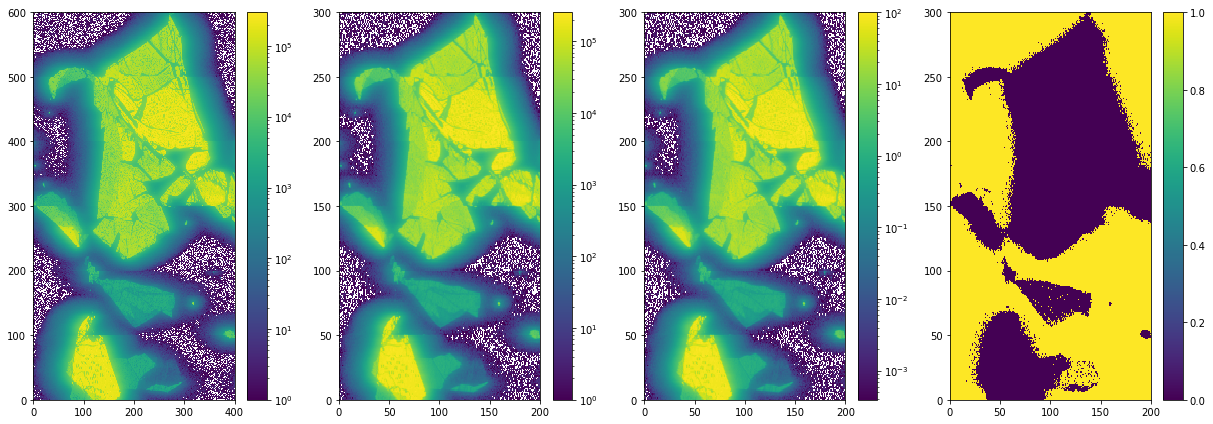

In [13]:
fig, axs = plt.subplots(1, 4, figsize=[17,6])
plt.subplot(1,4,1)
plt.pcolormesh(int1, cmap=cm, norm=cnorm())
plt.colorbar()
plt.subplot(1,4,2)
plt.pcolormesh(int_rescaled, cmap=cm, norm=cnorm())
plt.colorbar()
plt.subplot(1,4,3)
plt.pcolormesh(normalized_int, cmap=cm, norm=cnorm())
plt.colorbar()
plt.subplot(1,4,4)
plt.pcolormesh(xrf_threshold, cmap=cm)#, norm=cnorm())
plt.colorbar()
plt.tight_layout()

In [15]:
inner_batch_size = 100
initial_scan_points_num = 500

stop_ratio = 0.3
store_results_percentage = 1

affected_neighbors_window_min = 5
affected_neighbors_window_max = 15
full_erd_recalculation_frequency = 1

In [29]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=(300, 200),
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=normalized_int)

In [30]:
np.savetxt('instructions_000.csv', sample_params.initial_idxs, delimiter=',', fmt='%10d')

In [30]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [31]:
run_sampling(sample, results=results, results_frequency_step=1, results_frequency_percentage=0, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

Reached the stopping ratio set in the sample parameters. Stopping scan.


(<sladsnet.code.results.Result at 0x153220190>, 350)

In [23]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

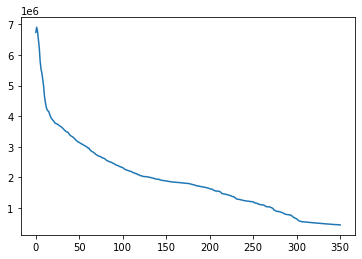

In [24]:
plt.plot(total_erds)

In [25]:
total_erds

array([6735309.5 , 6902380.5 , 6769801.  , 6489076.5 , 6225071.5 ,
       5800113.  , 5535043.  , 5405546.  , 5181764.5 , 4977492.5 ,
       4641562.5 , 4452544.5 , 4295793.5 , 4207388.  , 4171626.8 ,
       4144994.  , 4053293.2 , 3979323.5 , 3922815.8 , 3885574.5 ,
       3854299.  , 3825183.  , 3775469.  , 3761628.2 , 3747024.  ,
       3734959.2 , 3713447.5 , 3688033.2 , 3673358.5 , 3651529.  ,
       3638313.5 , 3602163.8 , 3572810.  , 3546189.8 , 3517062.  ,
       3492672.  , 3483306.2 , 3468414.8 , 3433042.2 , 3389110.  ,
       3362694.  , 3346894.5 , 3328759.5 , 3309771.  , 3283953.  ,
       3253839.  , 3220837.2 , 3197045.2 , 3169606.8 , 3157407.5 ,
       3140465.2 , 3121857.8 , 3102746.8 , 3084868.2 , 3076983.2 ,
       3051934.2 , 3039530.2 , 3024814.  , 3006322.  , 2987395.2 ,
       2958242.8 , 2959088.2 , 2907295.  , 2886473.2 , 2855244.5 ,
       2838038.5 , 2825765.2 , 2801462.5 , 2773705.  , 2752720.  ,
       2736799.5 , 2719648.8 , 2696181.2 , 2688494.  , 2684997

In [ ]:
1:18:56, 1:27:58

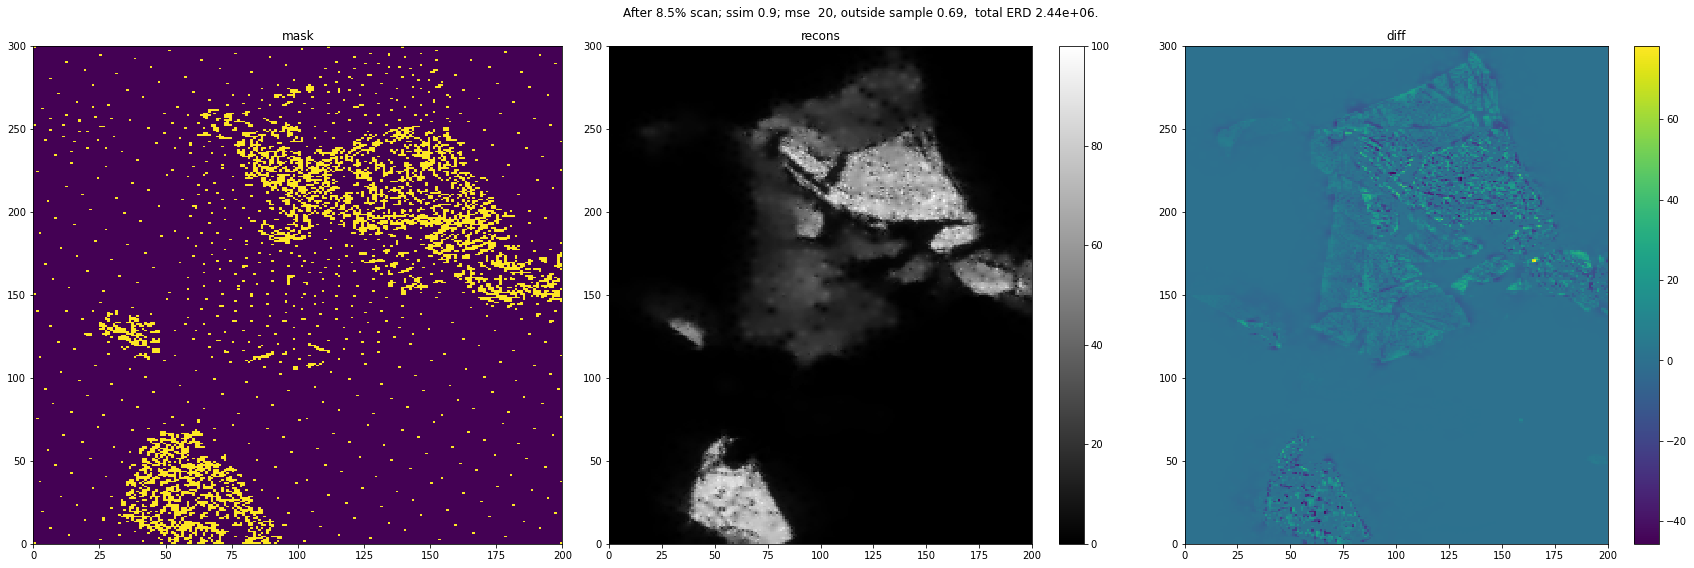

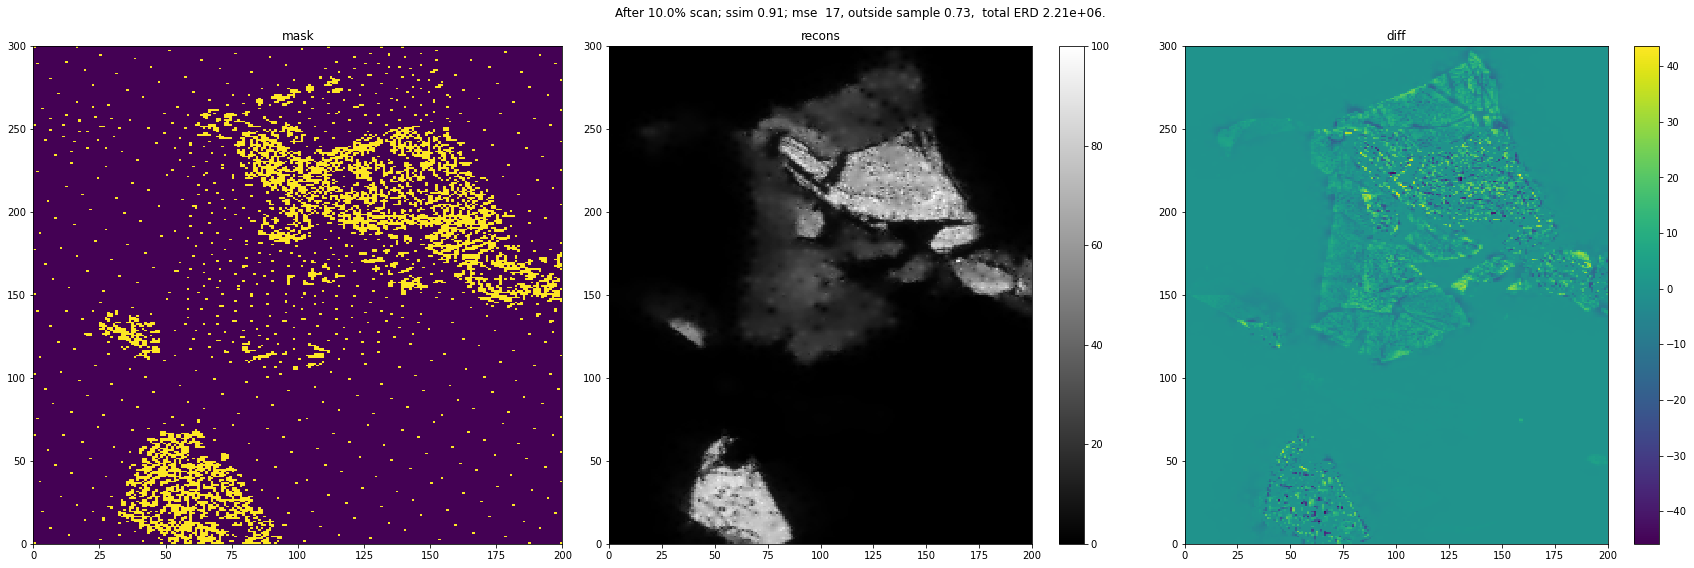

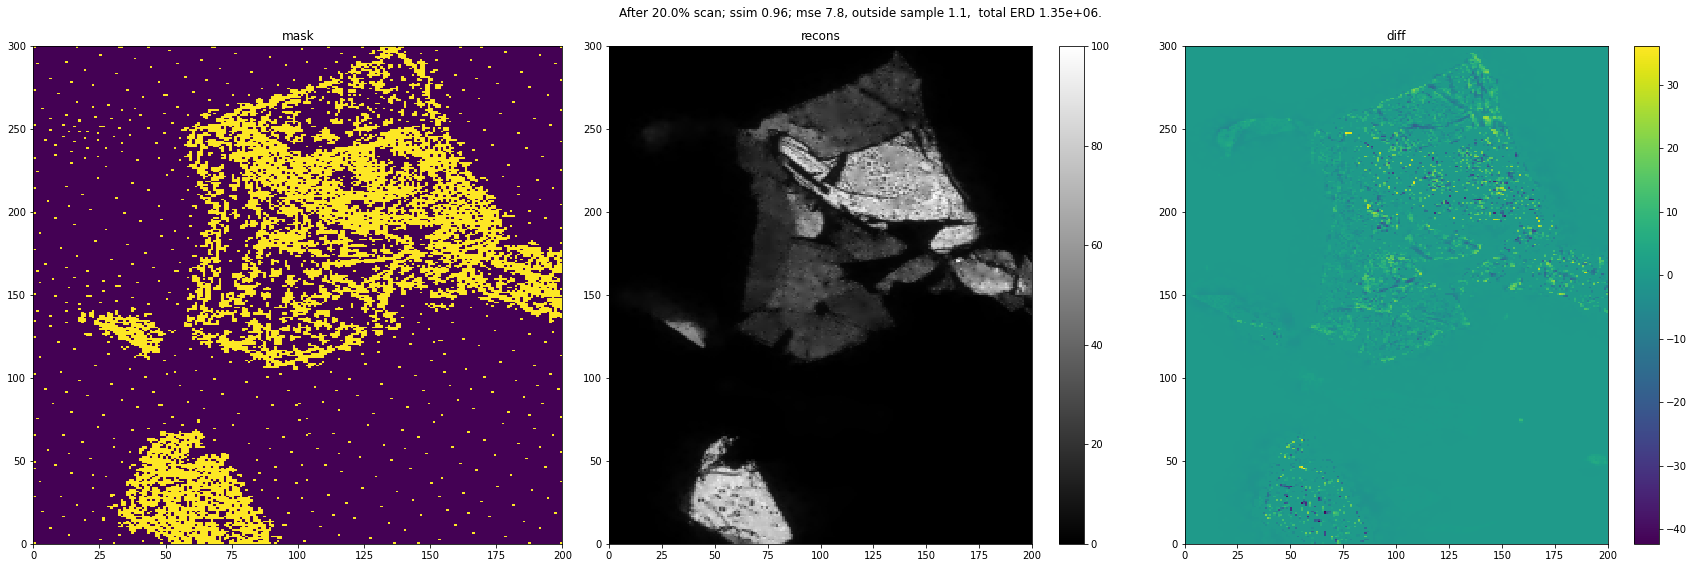

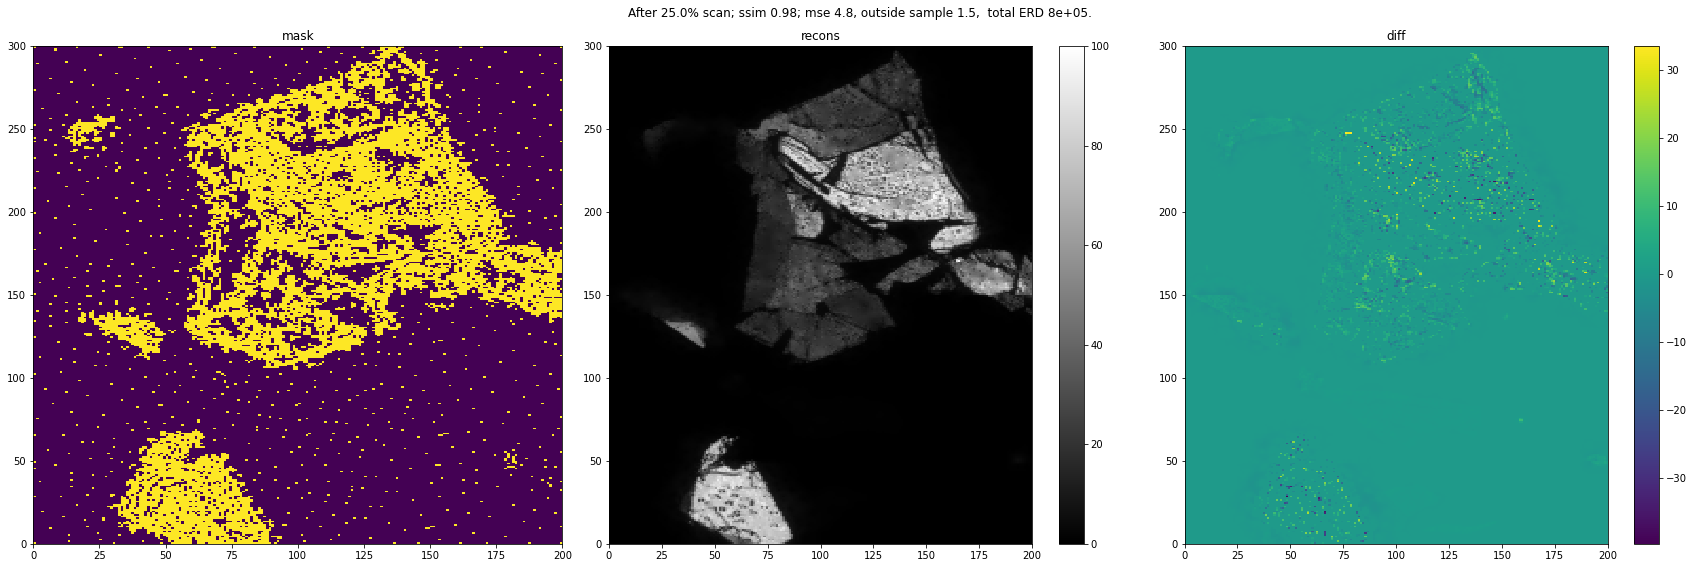

In [41]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 2)
    percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    #print(actual_percent)
    if percent not in [8.5, 10, 20, 25]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[24, 8])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap='gray')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, outside sample {percent_outside_sample:3.2g}, '\
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()
